In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"The Simulacra, Dick",267.147865,14.060414,35.118729,19
Windows PATH Variable,589.510608,19.650354,77.638122,30
Terraform,45.184348,22.592174,24.370891,2
Node.JS and React,1126.369656,36.334505,116.099771,31
Azure Compute Gallery,326.897133,46.699590,84.186719,7
"Mexican Gothic, Moreno-Garcia",1333.616640,47.629166,197.084955,28
Django,2145.632419,53.640810,231.851772,40
Azure Functions Core Tools,964.299958,56.723527,151.510873,17
Azure Files Documentation,3610.957951,63.350139,249.369614,57
Python,4869.362552,64.070560,245.722551,76


# Histogram

sum of ages: ~47145.01


<Axes: >

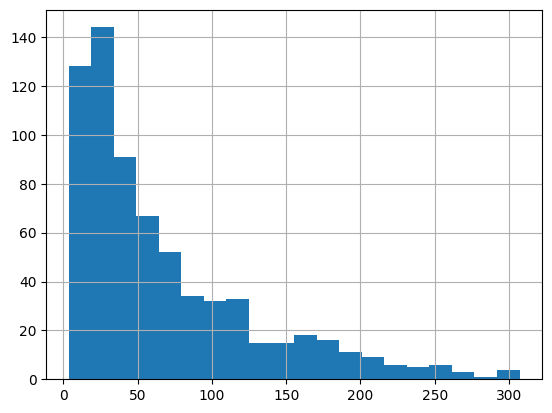

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~47145.01


<Axes: >

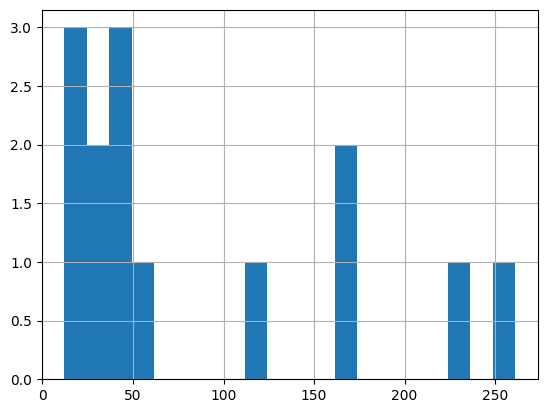

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Vocab']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 690
Total card age: 47145.01


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
0,Microsoft Purview,Run the policy in simulation mode with notific...,3a95ac540d1e377383ba60aeb1da4f08,307.049498,73.938710,307.049498,3549.058098,0.119348,48
1,Terraform Codebox,path.module in Terraform refers to the directo...,0077d1efc41777feb76ac15cfa44de56,293.302921,88.591784,293.302921,3455.079582,0.516790,39
2,Microsoft Purview,For organization-wide data consumers:\n Dat...,e30fb539c4e7b3fd2937525e3328ed8a,292.833799,73.938710,307.049498,3549.058098,0.119348,48
3,JavaScript Concepts,The basic syntax for a string template in Java...,950e996ffe32215d3aa7bacc2d81cc26,292.079819,84.639717,292.079819,3216.309230,0.980983,38
4,Active Directory and Azure Files,Kerberos Key (Storage Account key)\nA secret (...,7c008b725311d3b542f19e49340e719d,282.990906,80.596307,282.990906,2901.467046,0.338717,36
6,Python + Oauth2.0,http.server.SimpleHTTPRequestHandler\n\nA buil...,142b6319783bfbbf45e56e053e9a4c0c,271.308140,93.143693,271.308140,1956.017549,0.153081,21
5,Node.js and Vite,vite.config.js\nVite’s main configuration file...,6579af3b0c080942dce68776aa2d8914,271.134348,68.596217,271.134348,2812.444903,0.385769,41
7,Python + Oauth2.0,redirect_uri\n\nThe URL where the OAuth provid...,0f71673850ec4ac81e9d1d446c5f48a9,267.942743,93.143693,271.308140,1956.017549,0.153081,21
11,Vocab,"Jingo, Pratchett\nCruet\nnoun | KROO-it\nA sma...",528220646783dfd409ce4f2edf53a104,261.053431,88.848201,261.053431,1243.874821,0.700292,14
8,Asynchronous Python,return_exceptions=True (in gather)\nA paramete...,7b43de3dee4f46aa5adbf4020aff8165,260.746360,93.860402,260.746360,1595.626837,0.179703,17


# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
# n = random.choice([2, 3, 3, 4, 5, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(2800.441964098084)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
0,Microsoft Purview,Run the policy in simulation mode with notific...,3a95ac540d1e377383ba60aeb1da4f08,307.049498,73.938710,307.049498,3549.058098,0.119348,48
1,Terraform Codebox,path.module in Terraform refers to the directo...,0077d1efc41777feb76ac15cfa44de56,293.302921,88.591784,293.302921,3455.079582,0.516790,39
2,Microsoft Purview,For organization-wide data consumers:\n Dat...,e30fb539c4e7b3fd2937525e3328ed8a,292.833799,73.938710,307.049498,3549.058098,0.119348,48
3,JavaScript Concepts,The basic syntax for a string template in Java...,950e996ffe32215d3aa7bacc2d81cc26,292.079819,84.639717,292.079819,3216.309230,0.980983,38
4,Active Directory and Azure Files,Kerberos Key (Storage Account key)\nA secret (...,7c008b725311d3b542f19e49340e719d,282.990906,80.596307,282.990906,2901.467046,0.338717,36
6,Python + Oauth2.0,http.server.SimpleHTTPRequestHandler\n\nA buil...,142b6319783bfbbf45e56e053e9a4c0c,271.308140,93.143693,271.308140,1956.017549,0.153081,21
5,Node.js and Vite,vite.config.js\nVite’s main configuration file...,6579af3b0c080942dce68776aa2d8914,271.134348,68.596217,271.134348,2812.444903,0.385769,41
7,Python + Oauth2.0,redirect_uri\n\nThe URL where the OAuth provid...,0f71673850ec4ac81e9d1d446c5f48a9,267.942743,93.143693,271.308140,1956.017549,0.153081,21
11,Vocab,"Jingo, Pratchett\nCruet\nnoun | KROO-it\nA sma...",528220646783dfd409ce4f2edf53a104,261.053431,88.848201,261.053431,1243.874821,0.700292,14
8,Asynchronous Python,return_exceptions=True (in gather)\nA paramete...,7b43de3dee4f46aa5adbf4020aff8165,260.746360,93.860402,260.746360,1595.626837,0.179703,17


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 68.326'